In [1]:
import sys
import h5py
import numpy as np
import healpy as hp
import tensorflow as tf
import random as python_random
import nnhealpix.layers
import matplotlib.pyplot as plt
from tensorflow.keras import metrics
import keras
import pandas as pd
import os, shutil
import NN_functions as nuf
from loss_functions import sigma_loss, sigma_f_loss, sigma2_loss,sigma_batch_loss,sigma_norm_loss,sigma_log_loss,mse_tau,mse_sigma

2023-07-02 22:03:50.594314: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-02 22:03:51.851461: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-07-02 22:03:51.851631: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-07-02 22:03:51.851649: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
#metrics= [sigma_loss,sigma2_loss,sigma_batch_loss,sigma_norm_loss,sigma_log_loss,mse_tau,mse_sigma]
metrics= []
#home_dir="/home/amorelli/r_estimate/B_maps_white_noise/results_29_6_23/"
#home_dir_sigma="/home/amorelli/r_estimate/B_maps_white_noise/results_double_test/"
#load_dir='/home/amorelli/r_estimate/B_maps_white_noise/' 
home_dir="/home/amorelli/E_foreground/25_6_23/"
home_dir_sigma="/home/amorelli/E_foreground/29_6_23/"
load_dir='/home/amorelli/E_foreground/' 

test_model_folder="test_model"

#r_like=[0.0,0.01,0.03,0.05,0.06] #these are the r_test of the maps on which i test the NN 
#sigma_exact=[0.00011*2, 0.00152323164284316, 0.00286355246354494,0.00376209725434054,0.0024*2]
#to_load=["test_data_r000_t006_24.npz","test_data_r0010_t006_24.npz","test_data_r0030_t006_24.npz","test_data_r0050_t006_24.npz","test_data_r0060_t006_54.npz"]

#r_like=[0.0,0.001,0.005,0.007,0.01] #these are the r_test of the maps on which i test the NN 
#sigma_exact=[0.000225922*2, 0.000398311, 0.001017338,0.001142098,0.0015324*2] #these are the sigma computed for the 
#to_load=["test_data_r000_t006_77.npz","test_data_r001_t006_78.npz","test_data_r005_t006_79.npz",
         #"test_data_r007_t006_80.npz","test_data_r0010_t006_81.npz"] #these are the test maps

r_like=[0.01,0.05,0.06,0.07] #case EE foreground d1s1
sigma_exact=[0.00074403377826682*2,0.001945305515190439, 0.0020972936206641885 ,0.0022343595567425717] #these are the sigma computed for the 
to_load=["test_data_r000_t001_7.npz","test_data_r000_t005_8.npz","test_data_r000_t006_9.npz","test_data_r000_t007_10.npz"] #these are the test maps


#r_test using the likelihood approach
#sigma_exact=[0.00073*2, 0.000398311, 0.00207732328746706,0.002335838427700651] tau 0.01,0.06,0.07,0.08
#to_load=["test_data_005_40.npz","test_data_007_40.npz"]

loss_training=tf.keras.losses.MeanSquaredError() 
checkpoint_dir=home_dir+"checkpoints"
checkpoint_dir_sigma=home_dir_sigma+"checkpoints"
last_sigma=17
to_norm=True
map_norm=True
n_output=1
in_shape=2
nodes_per_layer=[64,256,256]
nside=16
use_drop=[False,True,True]
drop=[0.2,0.2,0.2]
n_layers=1
normalization=[False,False,False]

n_layers_tau=1
nodes_per_layer_tau=[48,12,12]
n_output_tau=2
use_drop_tau=[False,True,True]
drop_tau=[0.2,0.4,0.3]
normalization_tau=[False,False,False]
loss_training_tau=sigma_batch_loss
last_tau=50

In [3]:
try:
    hyperparameters=pd.read_csv(home_dir+"output.txt",delim_whitespace=True, index_col=None) #i try to read the 
    #file with the hyperparameters used in the training
except:
    print("no file to read") 
    dataframe={}
    dataframe["no data"]=["-"]
    hyperparameters=pd.DataFrame(dataframe)#if there is no file to read (because i analyse an old model) i create an 
    #empty dataframe
finally:
    None #i use this so that the program continue after the try,except
print(hyperparameters)

      name         loss  noise  p_stopping  p_reduce  f_reduce  \
0  25_6_23  sigma_batch      4          20         5       0.5   

         stop-reduce      lr  batch_size  n_layers nodes_per_layer comments  
0  val_loss-val_loss  0.0001          16         1     48-256-256-           


In [4]:
f_train=np.load(home_dir+"predictions.npz")
norm=f_train["norm"]
f_train_sigma=np.load(home_dir_sigma+"predictions.npz")
norm_sigma=f_train_sigma["norm"]

In [5]:
files=[]
for name in to_load: 
    files.append(np.load(load_dir+name) )
x_test=[]
y_test=[]
for i,f in enumerate(files):#i take the maps and the corresponding r_test for each input file
    x_test.append(f["x_test"])
    #y=np.zeros(len(x_test[i]))+f["y_test"] #y_test is a single number in the file -> i need to transform it in an array
    #of the same length of x_test
    #y_test.append(y.reshape(y.shape[0],1))    
    y_test.append(f["y_test"])

In [6]:
model=nuf.build_network(in_shape,nside,n_layers=n_layers_tau,layer_nodes=nodes_per_layer_tau,num_output=n_output_tau,
                  use_normalization=normalization_tau,use_drop=use_drop_tau,
                  drop=drop_tau,activation_dense="relu",kernel_initializer="glorot_uniform")
model.compile(loss=loss_training, optimizer=tf.optimizers.Adam(),metrics=metrics)

2023-07-02 22:03:58.637407: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-07-02 22:03:58.637549: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (coka.fe.infn.it): /proc/driver/nvidia/version does not exist
2023-07-02 22:03:58.639832: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
files=os.listdir(checkpoint_dir)
for f in files:
    splitted = f.split("-")
    if int(splitted[2])==last_tau:
        checkpoint_path=f
        break
print(checkpoint_path)
model.load_weights(checkpoint_dir+'/'+ checkpoint_path)

saved-weights-50-0.30275.hdf5


model = keras.models.load_model(home_dir+test_model_folder) #

In [8]:
model_sigma=nuf.build_network(in_shape,nside,n_layers=n_layers,layer_nodes=nodes_per_layer,num_output=n_output,
                  use_normalization=normalization,use_drop=use_drop,
                  drop=drop,activation_dense="relu",kernel_initializer="glorot_uniform")
model_sigma.compile(loss=loss_training, optimizer=tf.optimizers.Adam(),metrics=metrics)

In [9]:
files=os.listdir(checkpoint_dir_sigma)
for f in files:
    splitted = f.split("-")
    #print(splitted)
    if int(splitted[2])==last_sigma:
        checkpoint_path=f
        break
print(checkpoint_path)
model_sigma.load_weights(checkpoint_dir_sigma+'/'+ checkpoint_path)

saved-weights-17-0.98293.hdf5


In [10]:
results=[]
predictions=[]
for x,y in zip(x_test,y_test): #i compute the predictions of the model for each test_set and save them in a dict
    if map_norm:
        for i in range(len(x)):
            for j in range(in_shape):
                t=x[i,:,j]
                x[i,:,j]=nuf.normalize_data(t,t)
    #results.append(model.evaluate(x,y,verbose=2) )
    if n_output_tau==1:
        pred_tau=model.predict(x)
    else:
        pred_tau=model.predict(x)[:,0]
    pred_sigma=model_sigma.predict(x)
    pred=np.ones(shape=(len(pred_tau),2))
    if to_norm:
        #print(pred[:,0].shape)
        pred[:,0]=nuf.denormalize_data(pred_tau.flatten(),norm)
        pred[:,1]=nuf.denormalize_data(pred_sigma.flatten(),norm_sigma)
    predictions.append(pred)
npz_dict={}
for i,p in enumerate(predictions):
    npz_dict[f"sigma_{r_like[i]}"]=p[:,1]
np.savez(home_dir+"sigma_out", **npz_dict)

2023-07-02 22:04:01.578603: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 245760000 exceeds 10% of free system memory.


313/313 [==============================] - 7s 22ms/step


2023-07-02 22:04:09.798976: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 245760000 exceeds 10% of free system memory.


  4/313 [..............................] - ETA: 6s 

2023-07-02 22:04:19.078599: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 245760000 exceeds 10% of free system memory.


  4/313 [..............................] - ETA: 6s 

2023-07-02 22:04:26.208886: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 245760000 exceeds 10% of free system memory.


  4/313 [..............................] - ETA: 6s 

2023-07-02 22:04:34.823618: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 245760000 exceeds 10% of free system memory.


313/313 [==============================] - 7s 22ms/step


tau_pred=predictions[:,0]
sigma_pred=np.abs(predictions[:,1])#*predictions[:,1]
tau_est=np.mean(tau_pred)
sigma_tau=np.std(tau_pred)**2
#sigma_tau=np.sum((tau_pred-0.06)**2)/10000
sigma_est=np.mean(sigma_pred)
counts_tau, bins_tau = np.histogram(tau_pred)
counts_sigma, bins_sigma = np.histogram(sigma_pred)

In [13]:
r_pred=[]
var_pred=[]
r_est=[]
var_r=[]
var_est=[]
sigma_var=[]
mae_r=[]
skeweness_r=[]
skeweness_var=[]
median_r=[]
median_var=[]
for i,p in enumerate(predictions): #i compute mean, std, etc for each set of predictions and save them in the corresponding
    #dictionaries (see above)
    r_pred.append(p[:,0])
    #var_pred.append(p[:,1])
    var_pred.append(p[:,1])
    r_est.append(np.mean(r_pred[i]))
    var_r.append(np.std(r_pred[i])**2)
    var_est.append(np.mean(var_pred[i]))
    sigma_var.append(np.std(var_pred[i]))
    mae_r.append(np.sum(np.abs(r_pred[i]-r_est[i]))/len(r_pred[i]))
    skeweness_r.append(np.sum(((r_pred[i]-r_est[i])/var_r[i]**0.5)**3)/len(r_pred[i]))
    skeweness_var.append(np.sum(((var_pred[i]-var_est[i])/sigma_var[i])**3)/len(r_pred[i]))
    median_r.append(np.median(r_pred[i]))
    median_var.append(np.median(var_pred[i]))
#r_test=np.asarray([int(x*100)/100 for x in r_est])
#sigma_like=np.empty_like(r_test,dtype=float)
#for r in r_test:
    #i=r_like.index(r)
    #sigma_like[i]=sigma_exact[i]
d={}# i create a dictionary that stores the value of the following keywords for each test_set
d["r_test"]=r_like
d["r_est"]=r_est
d["dr"]=np.abs(np.asarray(r_like)-np.asarray(r_est))/r_est
d["median_r-r_est"]=np.asarray(median_r)-np.asarray(r_est)
d["mae_r"]=mae_r
d["skeweness_r"]=skeweness_r
sigma_r=np.asarray(var_r)**0.5
d["sigma_r"]=sigma_r
sigma_est=np.asarray(var_est)**0.5
d["sigma_est"]=sigma_est
d["dsigma"]=np.abs(np.asarray(sigma_r)-np.asarray(sigma_est))/sigma_est
d["dlike"]=np.abs(np.asarray(sigma_r)-np.asarray(sigma_exact))/sigma_r
d["sigma_var"]=sigma_var
d["median_var-var_est"]=np.asarray(median_var)-np.asarray(sigma_est)**2
d["skeweness_var"]=skeweness_var

r_data=pd.DataFrame(d)

#define new DataFrame as original DataFrame with each row repeated 3 times. I do this because i want to join the hyperpar. dataframe
#with the r_data dataframe and the hyperparam. dataframe only has one row
hp_new = pd.DataFrame(np.repeat(hyperparameters.values, len(r_est), axis=0))
#assign column names of original DataFrame to new DataFrame
hp_new.columns = hyperparameters.columns

out_df = pd.concat([hp_new, r_data], axis=1) # i join the two dataframes so that i can copy-paste all the info for one model directly
#in excel

print(out_df)
out_df.to_csv(home_dir_sigma+'results.txt', index=False, sep=';')

      name         loss noise p_stopping p_reduce f_reduce        stop-reduce  \
0  25_6_23  sigma_batch     4         20        5      0.5  val_loss-val_loss   
1  25_6_23  sigma_batch     4         20        5      0.5  val_loss-val_loss   
2  25_6_23  sigma_batch     4         20        5      0.5  val_loss-val_loss   
3  25_6_23  sigma_batch     4         20        5      0.5  val_loss-val_loss   

       lr batch_size n_layers  ... median_r-r_est     mae_r  skeweness_r  \
0  0.0001         16        1  ...      -0.000004  0.001443    -0.025000   
1  0.0001         16        1  ...      -0.000048  0.001988     0.121424   
2  0.0001         16        1  ...       0.000004  0.002166    -0.098387   
3  0.0001         16        1  ...      -0.000041  0.002150     0.016582   

    sigma_r  sigma_est    dsigma     dlike     sigma_var  median_var-var_est  \
0  0.001812   0.002540  0.286593  0.178816  6.099812e-07        8.361885e-09   
1  0.002491   0.002723  0.085016  0.219140  5.206838e

In [14]:
 for i in range(len(r_pred)):
    print("on_test_set r =",r_like[i])
    print("r_est:",r_est[i],"  This is the average of the $r_{i}^{NN}$ estimated by the network on the test set.")
    print("sigma_r:",sigma_r[i], " This is the std of the $r_i^{NN}$ array (std of the prediction).")
    print("sigma_r_est:", sigma_est[i], "  This is the square root of the average of the $\sigma_{i}$ estimated by the network on the test set. In this case the sigma_i is indeed an estimate of the variance")
    print("\n")

on_test_set r = 0.01
r_est: 0.009420070960000157   This is the average of the $r_{i}^{NN}$ estimated by the network on the test set.
sigma_r: 0.0018120994018531278  This is the std of the $r_i^{NN}$ array (std of the prediction).
sigma_r_est: 0.0025400641906965934   This is the square root of the average of the $\sigma_{i}$ estimated by the network on the test set. In this case the sigma_i is indeed an estimate of the variance


on_test_set r = 0.05
r_est: 0.048436338676512244   This is the average of the $r_{i}^{NN}$ estimated by the network on the test set.
sigma_r: 0.0024912333042230424  This is the std of the $r_i^{NN}$ array (std of the prediction).
sigma_r_est: 0.002722707639364555   This is the square root of the average of the $\sigma_{i}$ estimated by the network on the test set. In this case the sigma_i is indeed an estimate of the variance


on_test_set r = 0.06
r_est: 0.058865508845075964   This is the average of the $r_{i}^{NN}$ estimated by the network on the test set.
si

n_of_bins: 65
n_of_bins: 67
n_of_bins: 66
n_of_bins: 60


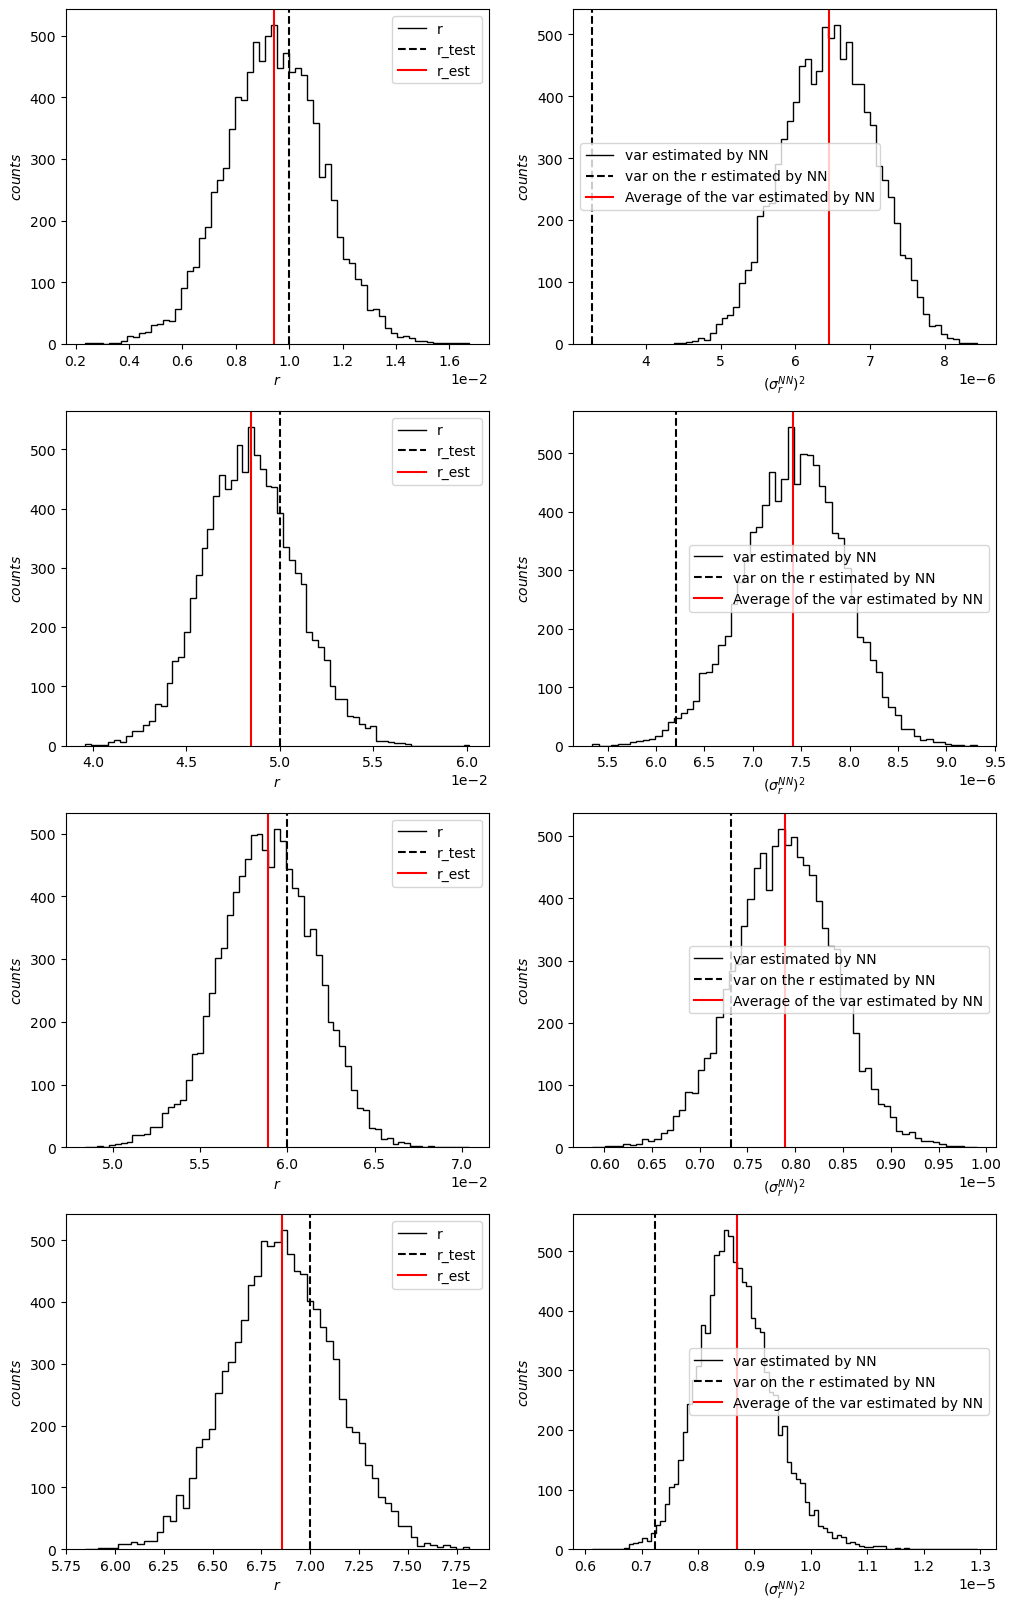

In [15]:
fig, ax = plt.subplots(len(r_pred),2, figsize = (12,20))
for i in range(len(r_pred)): #for each test_set i create an histogram of the r_pred and sigma_pred and print both 
    bin_size=100
    bin_edges= np.histogram_bin_edges(r_pred[i], bins='fd')
    print("n_of_bins:",len(bin_edges))
    counts_tau, bins_tau = np.histogram(r_pred[i], bins=bin_edges) 
    bin_edges= np.histogram_bin_edges(var_pred[i], bins='fd')
    counts_sigma, bins_sigma = np.histogram(var_pred[i], bins=bin_edges)
    plt.subplot(len(r_pred),2,2*i+1)
    plt.stairs(counts_tau, bins_tau, label="r",  color='k')
    plt.axvline(r_like[i], color="black", linestyle="--", label="r_test")
    #plt.axvline(median_r[i], color="black", linestyle="--", label="r_test")
    plt.axvline(r_est[i], color="red", linestyle="-", label="r_est")
    plt.legend()
    plt.xlabel("$r$")
    plt.ylabel("$counts$")
    plt.ticklabel_format(style='sci',useOffset=True, axis='x', scilimits=[-1, 1])
    plt.subplot(len(r_pred),2,2*i+2)
    plt.stairs(counts_sigma, bins_sigma, label="var estimated by NN",  color='k')
    plt.axvline(var_r[i], color="black", linestyle="--", label="var on the r estimated by NN")
    plt.axvline(var_est[i], color="red", linestyle="-", label="Average of the var estimated by NN")
    plt.legend()
    plt.ticklabel_format(style='sci',useOffset=True, axis='x', scilimits=[-1, 1])
    plt.xlabel("$(\sigma_{r}^{NN})^2$")
    plt.ylabel("$counts$")
    plt.legend()
    #print(counts_tau, bins_tau)
    #print(np.sort(r_pred[i]))
#plt.savefig('results_on_test.jpg') #must be in same cell or result image will be blank

In [16]:
print(sigma_r[1]**2)
print(sigma_est[1]**2)

6.206243376070058e-06
7.4131368894541084e-06


In [17]:
print(sigma_r[2]**2)
print(sigma_est[2]**2)

7.329949454772945e-06
7.894597051654274e-06


In [24]:
difference=(predictions[2][:,0]-0.06)**2
estimates=predictions[2][:,1]
print(np.mean(estimates),np.mean(difference),np.mean(difference-estimates))

7.894597051654272e-06 8.617019635373811e-06 7.224225837195381e-07


(0.0, 1e-05)

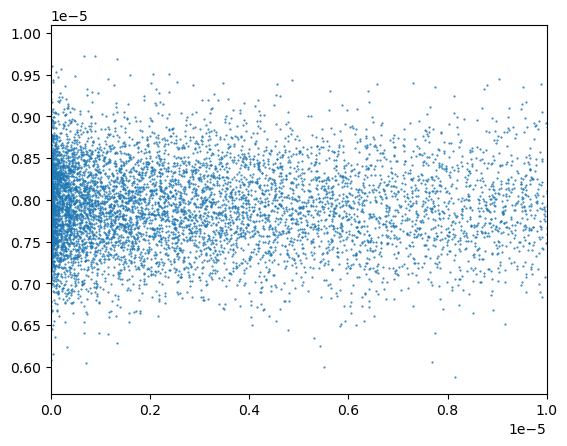

In [28]:
plt.plot(difference,estimates,linestyle="None",marker=".",markersize=1)
plt.xlim([0,1e-5])
#plt.plot(difference,difference,linestyle="None",marker=".",markersize=1)